# **PROJET STATION F**


In [10]:
# ======================================================
#  ⚙️ Préparation complète des données - Station F / Colab
#  Version améliorée :
#   - ignore les expériences sans date
#   - ne met plus 0.0 si durée inconnue → NaN
# ======================================================

import json
import pandas as pd
import numpy as np
import re
from datetime import datetime

# --- 1. Charger le fichier ---
DATA_PATH = "data/data_train.json"

# --- 2. Liste globale pour auditer les durées non reconnues ---
unrecognized_durations = []

# --- 3. Fonctions utilitaires ---

def extract_highest_degree_info(diplomas):
    """Retourne le niveau et le domaine du diplôme le plus élevé."""
    if not diplomas:
        return "Unknown", "Unknown"

    levels_order = ["Certificat", "Licence", "Master", "Doctorat"]
    best_level_idx = -1
    best_diploma = None

    for d in diplomas:
        level = d.get("level", "Unknown")
        if level in levels_order:
            idx = levels_order.index(level)
            if idx > best_level_idx:
                best_level_idx = idx
                best_diploma = d

    if best_diploma:
        return (
            best_diploma.get("level", "Unknown"),
            best_diploma.get("title", "Unknown")
        )
    else:
        return "Unknown", "Unknown"


def parse_duration_to_years(exp):
    """
    Retourne la durée en années pour une expérience individuelle.
    Essaie les formats : start_date/end_date, duration, dates.
    Renvoie np.nan si non reconnu ou non applicable.
    """
    now = pd.Timestamp.now()

    # Vérifier qu’il existe au moins une info temporelle
    if not any(k in exp for k in ["start_date", "end_date", "duration", "dates"]):
        return np.nan  # pas de durée du tout → on ignore

    # 1️⃣ Cas : start_date / end_date
    if "start_date" in exp and "end_date" in exp:
        start = pd.to_datetime(exp.get("start_date"), errors="coerce")
        end = exp.get("end_date")

        if isinstance(end, str) and re.search(r"présent|present", end, re.IGNORECASE):
            end = now
        else:
            end = pd.to_datetime(end, errors="coerce")

        if pd.notna(start) and pd.notna(end):
            return round((end - start).days / 365, 2)

    # 2️⃣ Cas : champ unique "duration"
    elif "duration" in exp and exp["duration"]:
        text = str(exp["duration"]).lower().strip()

        # Exemples : "6 mois", "5 ans", "1 an", "2015 - Présent"
        if re.search(r"\d+\s*mois", text):
            months = int(re.search(r"\d+", text).group())
            return round(months / 12, 2)

        elif re.search(r"\d+\s*an", text):
            years = int(re.search(r"\d+", text).group())
            return float(years)

        elif re.search(r"\d{4}", text):
            years = re.findall(r"\d{4}", text)
            if len(years) == 2:
                return int(years[1]) - int(years[0])
            elif len(years) == 1 and re.search(r"présent|present", text):
                return now.year - int(years[0])

    # 3️⃣ Cas : champ unique "dates"
    elif "dates" in exp and exp["dates"]:
        text = str(exp["dates"]).lower().strip()

        if re.search(r"\d{4}", text):
            years = re.findall(r"\d{4}", text)
            if len(years) == 2:
                return int(years[1]) - int(years[0])
            elif len(years) == 1 and re.search(r"présent|present", text):
                return now.year - int(years[0])

    # ❌ Cas non reconnu malgré une donnée
    if any(v for v in exp.values()):
        unrecognized_durations.append(exp)
    return np.nan


def total_experience_years(experiences):
    """
    Calcule la durée cumulée (en années) de toutes les expériences d’un formateur.
    Retourne NaN si aucune durée exploitable n’est trouvée.
    """
    if not experiences:
        return np.nan  # ⚠️ ne pas considérer comme 0 an

    durations = [parse_duration_to_years(exp) for exp in experiences]
    durations = [d for d in durations if pd.notna(d)]

    if not durations:
        return np.nan  # ⚠️ aucune info exploitable

    return round(sum(durations), 2)


def count_experiences(experiences):
    """Compte le nombre d'expériences professionnelles."""
    return len(experiences) if experiences else 0


def mean_past_rating(pastCourses):
    """Calcule la moyenne des notes passées."""
    if not pastCourses:
        return np.nan
    return np.mean([c.get("numberOfStars", np.nan) for c in pastCourses])


def flatten_entry(entry):
    """Aplati un professeur en plusieurs lignes (une par cours)."""
    flattened = []
    highest_level, highest_domain = extract_highest_degree_info(entry.get("diplomas"))
    total_years = total_experience_years(entry.get("experiences"))  # ✅ uniquement sur experiences

    for course in entry.get("pastCourses", []):
        flattened.append({
            "firstname": entry.get("fistname") or entry.get("firstname"),
            "lastname": entry.get("lastname"),
            "city": entry.get("city", "Unknown"),
            "description": entry.get("description", ""),
            "highest_degree": highest_level,
            "highest_degree_domain": highest_domain,
            "num_diplomas": len(entry.get("diplomas", [])),
            "num_experiences": count_experiences(entry.get("experiences")),
            "total_experience_years": total_years,  # 🆕 NaN si inconnu, pas 0
            "mean_past_rating": mean_past_rating(entry.get("pastCourses")),
            "course_title": course.get("title", "Unknown"),
            "course_rating": course.get("numberOfStars", np.nan)
        })
    return flattened


# --- 4. Charger et transformer les données ---
with open(DATA_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)

rows = []
for teacher in data:
    rows.extend(flatten_entry(teacher))

df = pd.DataFrame(rows)

# --- 5. Nettoyage rapide ---
df.dropna(subset=["course_rating"], inplace=True)
df.reset_index(drop=True, inplace=True)

# --- 6. Résumé + audit ---
print(f"Nombre total de cours : {len(df)}")
print(f"Nombre d'expériences non reconnues : {len(unrecognized_durations)}")

if unrecognized_durations:
    print("\n🔍 Exemple d’expérience non reconnue :")
    for e in unrecognized_durations[:3]:
        print(e)

print("\n✅ Exemple de lignes formatées :")
df.head(10)


Nombre total de cours : 1599
Nombre d'expériences non reconnues : 1

🔍 Exemple d’expérience non reconnue :
{'title': 'Assistant Formateur - Cours de Programmation Python', 'company': 'Coderia', 'dates': '2017'}

✅ Exemple de lignes formatées :


,firstname,lastname,city,description,highest_degree,highest_degree_domain,num_diplomas,num_experiences,total_experience_years,mean_past_rating,course_title,course_rating
0,Antoine Dubois,Moreau,Paris,"Formateur expérimenté en informatique, passion...",Master,Master en Intelligence Artificielle,2,3,NaN,4.725,Introduction à l'Intelligence Artificielle,4.8
1,Antoine Dubois,Moreau,Paris,"Formateur expérimenté en informatique, passion...",Master,Master en Intelligence Artificielle,2,3,NaN,4.725,Programmation Orientée Objet,4.5
2,Antoine Dubois,Moreau,Paris,"Formateur expérimenté en informatique, passion...",Master,Master en Intelligence Artificielle,2,3,NaN,4.725,Algorithmique et Structures de Données,4.7
3,Antoine Dubois,Moreau,Paris,"Formateur expérimenté en informatique, passion...",Master,Master en Intelligence Artificielle,2,3,NaN,4.725,Développement Web avec JavaScript,4.9
4,Jean-Luc Dubois,Bernard,Paris,Formateur expérimenté en développement informa...,Licence,Licence en Informatique,3,3,NaN,4.550,Programmation Orientée Objet,4.8
5,Jean-Luc Dubois,Bernard,Paris,Formateur expérimenté en développement informa...,Licence,Licence en Informatique,3,3,NaN,4.550,Développement Web avec React,4.5
6,Jean-Luc Dubois,Bernard,Paris,Formateur expérimenté en développement informa...,Licence,Licence en Informatique,3,3,NaN,4.550,Algorithmes et Structures de Données,4.2
7,Jean-Luc Dubois,Bernard,Paris,Formateur expérimenté en développement informa...,Licence,Licence en Informatique,3,3,NaN,4.550,Développement en Python,4.7
8,Jean-Luc Dubois,Moreau,Paris,Formateur passionné et expérimenté en développ...,Doctorat,Doctorat en Intelligence Artificielle,2,3,6.5,4.675,Introduction aux Bases de Code,4.9
9,Jean-Luc Dubois,Moreau,Paris,Formateur passionné et expérimenté en développ...,Doctorat,Doctorat en Intelligence Artificielle,2,3,6.5,4.675,Frameworks Web (React & Angular),4.7


In [11]:
%pip install scikit-learn

# ======================================================
#  ✂️ Split du jeu de données : train / test
# ======================================================

from sklearn.model_selection import train_test_split

# --- 1. Définir la cible et les features ---
y = df["course_rating"]
X = df.drop(columns=["course_rating", "firstname", "lastname"])

# --- 2. Découpage train / test ---
# 80% pour l'entraînement, 20% pour le test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# --- 3. Vérification des dimensions ---
print(f"🧩 Taille totale : {df.shape[0]} échantillons")
print(f"📘 Entraînement : {X_train.shape[0]} ({100 * X_train.shape[0] / df.shape[0]:.1f}%)")
print(f"📙 Test : {X_test.shape[0]} ({100 * X_test.shape[0] / df.shape[0]:.1f}%)")

# --- 4. Aperçu rapide ---
print("\n✅ Exemple d'une ligne de X_train :")
display(X_train.head(10))

print("\n🎯 Exemple des valeurs cibles (y_train) :")
display(y_train.head(5))



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
🧩 Taille totale : 1599 échantillons
📘 Entraînement : 1279 (80.0%)
📙 Test : 320 (20.0%)

✅ Exemple d'une ligne de X_train :


,city,description,highest_degree,highest_degree_domain,num_diplomas,num_experiences,total_experience_years,mean_past_rating,course_title
493,Paris,Formateur passionné et expérimenté en développ...,Unknown,Unknown,2,3,7.00,4.500,Introduction aux Bases de Code
354,Paris,"Formateur expérimenté en informatique, spécial...",Doctorat,Doctorat en Intelligence Artificielle,2,3,NaN,4.500,Introduction aux Bases de Données
342,Paris,Formateur passionné et expérimenté en développ...,Master,Master en Informatique,2,3,NaN,4.500,Introduction à la Programmation Python
834,Paris,Formateur expérimenté en développement informa...,Doctorat,Diplôme d'Ingénieur Informatique,3,3,22.26,4.700,Data Structures and Algorithms
705,Paris,Formateur expérimenté en développement informa...,Master,Master en Informatique,2,3,NaN,4.375,Développement Mobile avec Swift
522,Paris,"Formateur passionné en informatique, spécialis...",Certificat,Certificat de Formation en Conception Logicielle,2,3,6.50,4.725,Introduction à la Programmation
1590,Paris,Formateur expérimenté en développement informa...,Master,Master en Intelligence Artificielle,2,3,NaN,4.700,Développement Mobile avec React Native
1404,Paris,"Formateur expérimenté en informatique, spécial...",Licence,Licence en Informatique,2,3,12.00,4.700,Data Science avec Python
1055,Paris,Formateur passionné et expérimenté en informat...,Licence,Licence en Informatique,3,3,7.08,4.440,Python pour Débutants
277,Paris,Formateur et professeur expérimenté en informa...,Doctorat,Doctorat en Intelligence Artificielle,2,3,12.33,4.700,Data Structures et Algorithmes



🎯 Exemple des valeurs cibles (y_train) :


493    4.8
354    4.8
342    4.8
834    4.6
705    4.0
Name: course_rating, dtype: float64

In [12]:
# Test d'adaptation aux incconus


# ======================================================
#  💪 Version robuste du pipeline - Support explicite de "Inconnu"
# ======================================================

%pip install nltk

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from nltk.corpus import stopwords
import nltk
import random

nltk.download("stopwords")
french_stopwords = stopwords.words("french")

# --- 1️⃣ Fonction pour injecter des "Inconnu" aléatoirement ---
def simulate_unknowns(df, p=0.1):
    """
    Injecte des valeurs 'Inconnu' ou NaN dans un DataFrame
    pour habituer le modèle à gérer des champs manquants.
    """
    df_sim = df.copy()
    for col in df_sim.columns:
        mask = np.random.rand(len(df_sim)) < p
        if df_sim[col].dtype == object:
            df_sim.loc[mask, col] = "Inconnu"
        else:
            df_sim.loc[mask, col] = np.nan
    return df_sim

# --- 2️⃣ Colonnes par type ---
numeric_features = ["num_diplomas", "num_experiences", "total_experience_years", "mean_past_rating"]
categorical_features = ["city", "highest_degree", "highest_degree_domain"]
text_features = ["description", "course_title"]

# --- 3️⃣ Pipelines de transformation ---
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Inconnu")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# On remplace les NaN textuels par "Inconnu"
def fill_text_unknowns(df):
    for col in text_features:
        df[col] = df[col].fillna("Inconnu")
        df[col] = df[col].replace("", "Inconnu")
    return df

# --- 4️⃣ Préprocesseur global ---
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features),
    ("desc_tfidf", TfidfVectorizer(max_features=300, stop_words=french_stopwords), "description"),
    ("title_tfidf", TfidfVectorizer(max_features=300, stop_words=french_stopwords), "course_title")
])

# --- 5️⃣ Pipeline complet ---
model_robust = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=150,
        random_state=42,
        n_jobs=-1
    ))
])

# --- 6️⃣ Préparation des données ---
X_train_aug = simulate_unknowns(X_train, p=0.15)
X_train_aug = fill_text_unknowns(X_train_aug)
X_test = fill_text_unknowns(X_test)

# --- 7️⃣ Entraînement ---
model_robust.fit(X_train_aug, y_train)

# --- 8️⃣ Évaluation ---
y_pred = model_robust.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"✅ MAE (modèle robuste) : {mae:.3f}")
print(f"✅ RMSE (modèle robuste) : {rmse:.3f}")

# --- 9️⃣ Comparaison échantillon ---
comparison = pd.DataFrame({
    "Vraie note": y_test.values[:10],
    "Prédiction": np.round(y_pred[:10], 2)
})
display(comparison)



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/browngreg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ MAE (modèle robuste) : 0.165
✅ RMSE (modèle robuste) : 0.233


,Vraie note,Prédiction
0,4.2,4.54
1,4.7,4.44
2,4.5,4.37
3,4.5,4.44
4,3.7,4.34
5,4.8,4.81
6,4.8,4.27
7,4.8,4.41
8,4.2,4.16
9,4.5,4.60



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_8979/983317483.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped.head(15), x="Importance", y="Feature_grouped", palette="mako")


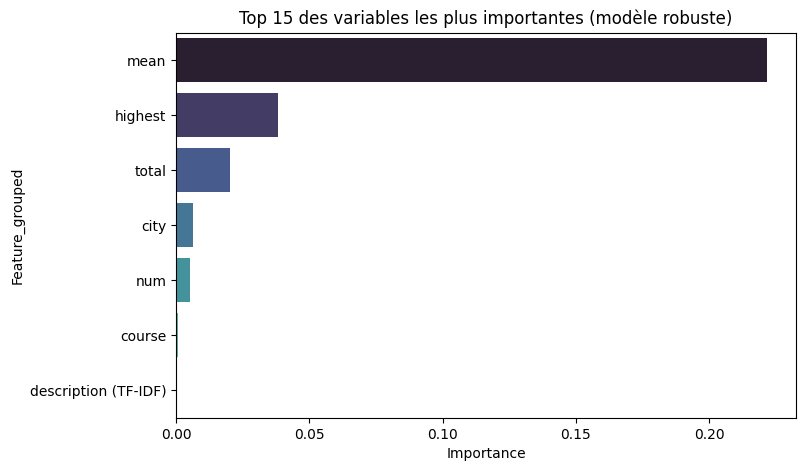

,Feature_grouped,Importance
4,mean,0.221473
3,highest,0.038125
6,total,0.020272
0,city,0.006214
5,num,0.005350
1,course,0.000795
2,description (TF-IDF),0.000433


In [15]:
%pip install matplotlib
%pip install seaborn

# ======================================================
#  🔍 Importance des variables - modèle robuste
# ======================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extraire le modèle et le preprocess
rf = model_robust.named_steps["regressor"]
preprocessor = model_robust.named_steps["preprocessor"]

# 1️⃣ Récupérer les noms des features
# --- numériques ---
num_features = preprocessor.transformers_[0][2]

# --- catégorielles (avec one-hot) ---
cat_encoder = preprocessor.transformers_[1][1].named_steps["onehot"]
cat_features = list(cat_encoder.get_feature_names_out(preprocessor.transformers_[1][2]))

# --- textes : on ne les détaille pas individuellement (trop nombreux), mais on les regroupe
text_features = ["description (TF-IDF)", "course_title (TF-IDF)"]

# 2️⃣ Fusionner les noms (numériques + catégoriques)
feature_names = list(num_features) + cat_features + text_features

# 3️⃣ Récupérer les importances du RandomForest
importances = rf.feature_importances_[:len(feature_names)]

# 4️⃣ Construire un DataFrame propre
feat_importances = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# 5️⃣ Regrouper les très nombreux dummy features
feat_importances["Feature_grouped"] = feat_importances["Feature"].apply(
    lambda x: x.split("_")[0] if "_" in x else x
)
grouped = feat_importances.groupby("Feature_grouped")["Importance"].sum().reset_index()
grouped = grouped.sort_values("Importance", ascending=False)

# 6️⃣ Afficher les 15 plus influentes
plt.figure(figsize=(8, 5))
sns.barplot(data=grouped.head(15), x="Importance", y="Feature_grouped", palette="mako")
plt.title("Top 15 des variables les plus importantes (modèle robuste)")
plt.show()

# 7️⃣ Affichage tabulaire détaillé
display(grouped.head(20))


In [16]:
# ======================================================
#  🧪 Modèle prospectif (aucune note moyenne utilisée)
# ======================================================

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import nltk

nltk.download("stopwords")
french_stopwords = stopwords.words("french")

# --- Colonnes sans mean_past_rating ---
numeric_features = ["num_diplomas", "num_experiences", "total_experience_years"]
categorical_features = ["city", "highest_degree", "highest_degree_domain"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Inconnu")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features),
    ("desc_tfidf", TfidfVectorizer(max_features=300, stop_words=french_stopwords), "description"),
    ("title_tfidf", TfidfVectorizer(max_features=300, stop_words=french_stopwords), "course_title")
])

model_prospectif = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

# --- Entraînement ---
model_prospectif.fit(X_train, y_train)
y_pred_prospectif = model_prospectif.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_prospectif)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_prospectif))

print(f"✅ MAE (sans mean_past_rating) : {mae:.3f}")
print(f"✅ RMSE (sans mean_past_rating) : {rmse:.3f}")


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/browngreg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ MAE (sans mean_past_rating) : 0.190
✅ RMSE (sans mean_past_rating) : 0.252


/tmp/ipykernel_8979/1721985026.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped.head(15), x="Importance", y="Feature_grouped", palette="mako")


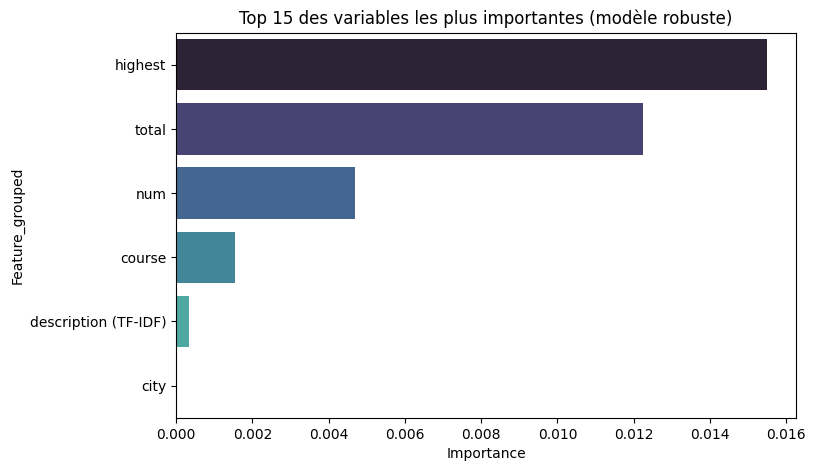

,Feature_grouped,Importance
3,highest,0.015484
5,total,0.012233
4,num,0.004685
1,course,0.001533
2,description (TF-IDF),0.000340
0,city,0.000000


In [17]:
# ======================================================
#  🔍 Importance des variables - modèle robuste
# ======================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extraire le modèle et le preprocess
rf = model_prospectif.named_steps["regressor"]
preprocessor = model_prospectif.named_steps["preprocessor"]

# 1️⃣ Récupérer les noms des features
# --- numériques ---
num_features = preprocessor.transformers_[0][2]

# --- catégorielles (avec one-hot) ---
cat_encoder = preprocessor.transformers_[1][1].named_steps["onehot"]
cat_features = list(cat_encoder.get_feature_names_out(preprocessor.transformers_[1][2]))

# --- textes : on ne les détaille pas individuellement (trop nombreux), mais on les regroupe
text_features = ["description (TF-IDF)", "course_title (TF-IDF)"]

# 2️⃣ Fusionner les noms (numériques + catégoriques)
feature_names = list(num_features) + cat_features + text_features

# 3️⃣ Récupérer les importances du RandomForest
importances = rf.feature_importances_[:len(feature_names)]

# 4️⃣ Construire un DataFrame propre
feat_importances = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# 5️⃣ Regrouper les très nombreux dummy features
feat_importances["Feature_grouped"] = feat_importances["Feature"].apply(
    lambda x: x.split("_")[0] if "_" in x else x
)
grouped = feat_importances.groupby("Feature_grouped")["Importance"].sum().reset_index()
grouped = grouped.sort_values("Importance", ascending=False)

# 6️⃣ Afficher les 15 plus influentes
plt.figure(figsize=(8, 5))
sns.barplot(data=grouped.head(15), x="Importance", y="Feature_grouped", palette="mako")
plt.title("Top 15 des variables les plus importantes (modèle robuste)")
plt.show()

# 7️⃣ Affichage tabulaire détaillé
display(grouped.head(20))


In [18]:
# ======================================================
#  💾 Sauvegarde des modèles - Robuste & Prospectif
# ======================================================

import joblib

# Sauvegarde du modèle robuste (avec "Inconnu" et mean_past_rating)
joblib.dump(model_robust, "model_robust.pkl")
print("✅ Modèle robuste sauvegardé : model_robust.pkl")

# Sauvegarde du modèle prospectif (aucune note historique)
joblib.dump(model_prospectif, "model_prospectif.pkl")
print("✅ Modèle prospectif sauvegardé : model_prospectif.pkl")


✅ Modèle robuste sauvegardé : model_robust.pkl
✅ Modèle prospectif sauvegardé : model_prospectif.pkl


📊 Comparaison des erreurs globales :


,Modèle,MAE,RMSE
0,Robuste (avec notes),0.155816,0.219496
1,Prospectif (sans notes),0.189500,0.251645


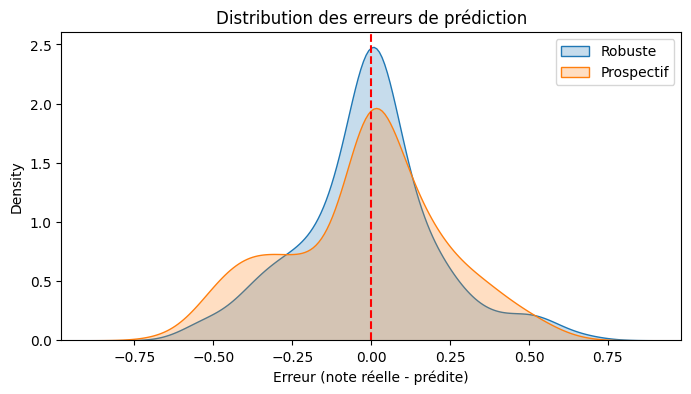

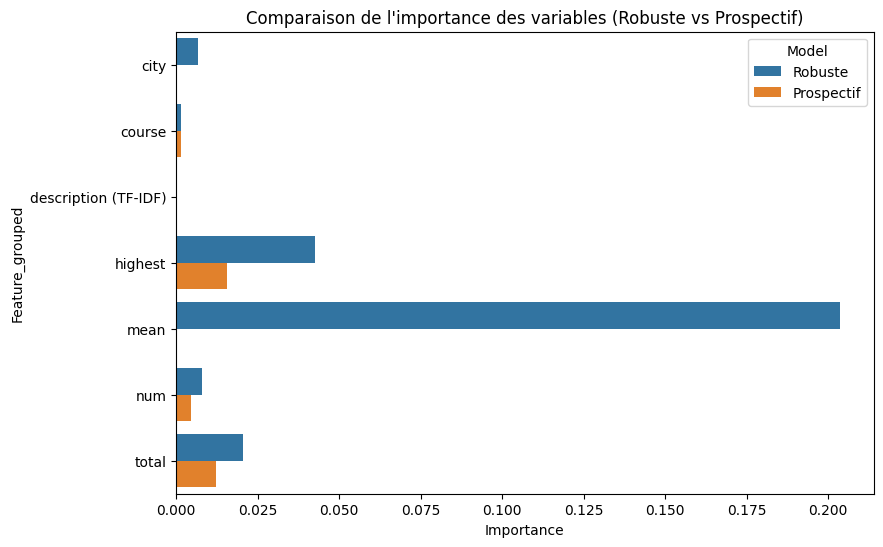

Model,Prospectif,Robuste,Différence
Feature_grouped,,,
mean,0.000000,0.203691,2.036912e-01
highest,0.015543,0.042758,2.721531e-02
total,0.012185,0.020618,8.432220e-03
city,0.000000,0.006805,6.805162e-03
num,0.004698,0.007944,3.246142e-03
description (TF-IDF),0.000349,0.000348,-8.886097e-07
course,0.001540,0.001447,-9.299209e-05


In [ ]:
# ======================================================
#  📊 Analyse comparative des deux modèles (Robuste vs Prospectif)
# ======================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1️⃣ Prédictions des deux modèles sur le même X_test ---
y_pred_robust = model_robust.predict(X_test)
y_pred_prospectif = model_prospectif.predict(X_test)

mae_robust = mean_absolute_error(y_test, y_pred_robust)
rmse_robust = np.sqrt(mean_squared_error(y_test, y_pred_robust))

mae_prosp = mean_absolute_error(y_test, y_pred_prospectif)
rmse_prosp = np.sqrt(mean_squared_error(y_test, y_pred_prospectif))

# --- 2️⃣ Résumé global ---
results = pd.DataFrame({
    "Modèle": ["Robuste (avec notes)", "Prospectif (sans notes)"],
    "MAE": [mae_robust, mae_prosp],
    "RMSE": [rmse_robust, rmse_prosp]
})
print("📊 Comparaison des erreurs globales :")
display(results)

# --- 3️⃣ Distribution des erreurs ---
errors_robust = y_test - y_pred_robust
errors_prosp = y_test - y_pred_prospectif

plt.figure(figsize=(8,4))
sns.kdeplot(errors_robust, fill=True, label="Robuste")
sns.kdeplot(errors_prosp, fill=True, label="Prospectif")
plt.axvline(0, color="red", linestyle="--")
plt.title("Distribution des erreurs de prédiction")
plt.xlabel("Erreur (note réelle - prédite)")
plt.legend()
plt.show()

# --- 4️⃣ Importance des variables pour chaque modèle ---
def get_feature_importances(model, model_name):
    rf = model.named_steps["regressor"]
    preprocessor = model.named_steps["preprocessor"]

    num_features = preprocessor.transformers_[0][2]
    cat_encoder = preprocessor.transformers_[1][1].named_steps["onehot"]
    cat_features = list(cat_encoder.get_feature_names_out(preprocessor.transformers_[1][2]))
    text_features = ["description (TF-IDF)", "course_title (TF-IDF)"]
    feature_names = list(num_features) + cat_features + text_features

    importances = rf.feature_importances_[:len(feature_names)]

    feat_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances,
        "Model": model_name
    })
    feat_df["Feature_grouped"] = feat_df["Feature"].apply(
        lambda x: x.split("_")[0] if "_" in x else x
    )
    grouped = feat_df.groupby(["Model", "Feature_grouped"])["Importance"].sum().reset_index()
    return grouped

feat_robust = get_feature_importances(model_robust, "Robuste")
feat_prosp = get_feature_importances(model_prospectif, "Prospectif")

# --- Fusion pour comparaison ---
feat_compare = pd.concat([feat_robust, feat_prosp])

plt.figure(figsize=(9,6))
sns.barplot(data=feat_compare, x="Importance", y="Feature_grouped", hue="Model")
plt.title("Comparaison de l'importance des variables (Robuste vs Prospectif)")
plt.show()

# --- 5️⃣ Aperçu tabulaire ---
feat_pivot = feat_compare.pivot(index="Feature_grouped", columns="Model", values="Importance").fillna(0)
feat_pivot["Différence"] = feat_pivot["Robuste"] - feat_pivot["Prospectif"]
display(feat_pivot.sort_values("Différence", ascending=False))

In [19]:
# ======================================================
#  🧪 Test local d'une prédiction - Professeur & Cours
# ======================================================

import pandas as pd

# --- Exemple 1 : professeur avec historique connu (modèle robuste) ---
prof_robuste = {
    "city": "Paris",
    "highest_degree": "Master",
    "highest_degree_domain": "Informatique",
    "num_diplomas": 2,
    "num_experiences": 4,
    "total_experience_years": 6,
    "mean_past_rating": 4.6,  # ✅ connu
    "description": "Formateur expérimenté en data science et IA appliquée.",
    "course_title": "Machine Learning avancé"
}

# --- Exemple 2 : nouveau professeur sans historique (modèle prospectif) ---
prof_prospectif = {
    "city": "Paris",
    "highest_degree": "Doctorat",
    "highest_degree_domain": None,
    "num_diplomas": None,
    "num_experiences": None,
    "total_experience_years": 6,
    "mean_past_rating": None,  # ✅ connu
    "description": "N",
    "course_title": "Web"
}


# --- Convertir en DataFrame ---
df_robuste = pd.DataFrame([prof_robuste])
df_prospectif = pd.DataFrame([prof_prospectif])

# --- Prédiction avec le modèle approprié ---
pred_robuste = model_robust.predict(df_robuste)[0]
pred_prospectif = model_prospectif.predict(df_prospectif)[0]

# --- Résultats propres ---
print("🧑‍🏫 Professeur AVEC historique")
print(f"→ Prédiction (modèle robuste) : {round(float(pred_robuste), 2)} / 5\n")

print("👩‍🏫 Nouveau professeur (SANS historique)")
print(f"→ Prédiction (modèle prospectif) : {round(float(pred_prospectif), 2)} / 5")


🧑‍🏫 Professeur AVEC historique
→ Prédiction (modèle robuste) : 4.75 / 5

👩‍🏫 Nouveau professeur (SANS historique)
→ Prédiction (modèle prospectif) : 4.46 / 5
